In [44]:
from transformers import (
    AutoFeatureExtractor,
    Wav2Vec2BertForSequenceClassification, 
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback 
    )
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import torch
import IPython.display as ipd
import librosa
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import os
from torch.nn.utils.rnn import pad_sequence
from datasets import load_metric
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
from collections import Counter


device = "cuda" if torch.cuda.is_available() else "cpu"


### Dataset

##### Dataset Used: RAVDESS Emotional speech audio
##### Link: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


### Data Loading

In [2]:
def load_emotion_dataset(data_dir):
  data = {"train": [], "valid": []}
  for split in ["Train", "Valid"]:
    split_dir = os.path.join(data_dir, split)
    for emotion in os.listdir(split_dir):
      emotion_dir = os.path.join(split_dir, emotion)
      if os.path.isdir(emotion_dir):
        for file_name in os.listdir(emotion_dir):
          if file_name.endswith(".wav"):
            file_path = os.path.join(emotion_dir, file_name)
  
            # Convert emotion label to integer using the dictionary
            label = label2id[emotion]
  
            data[split.lower()].append({"path": file_path, "label": label})
  return data


# Emotion labels dictionary
label2id = {"neutral": 0, "calm": 1, "happy": 2, "sad": 3, "angry": 4, "fearful": 5, "disgust":6, "surprised":7}
id2label = {v: k for k, v in label2id.items()}

data_dir = r"RAVDESS dataset"

raw_data = load_emotion_dataset(data_dir)

# Convert to Hugging Face Dataset
dataset = DatasetDict({
    "train": Dataset.from_list(raw_data["train"]),
    "valid": Dataset.from_list(raw_data["valid"]),
})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label'],
        num_rows: 1155
    })
    valid: Dataset({
        features: ['path', 'label'],
        num_rows: 285
    })
})

In [3]:
label_counts = Counter(dataset['valid']['label'])
print(label_counts)

Counter({4: 38, 1: 38, 6: 38, 5: 38, 2: 38, 3: 38, 7: 38, 0: 19})


In [4]:
audio_path_and_length = []
for i in range(len(dataset['train']['path'])):
    audio_path = dataset['train']['path'][i]
    audio, sr = librosa.load(audio_path, sr=16_000)   
    audio_path_and_length.append((audio_path, len(audio)))

In [46]:
# Extract lengths from the list of tuples
audio_lengths = [length for path, length in audio_path_and_length]
mean_audio_length = int(np.mean(audio_lengths))
max_audio_length = int(np.max(audio_lengths))
min_audio_length = int(np.min(audio_lengths))

print(f"Mean audio length: {mean_audio_length}")
print(f"Max audio length: {max_audio_length}")
print(f"Min audio length: {min_audio_length}")


Mean audio length: 59148
Max audio length: 84351
Min audio length: 46981


### Data Preprocessing

In [6]:
def preprocess_function(data):
    audio, sr = librosa.load(data["path"], sr=16_000)  
    audio = torch.tensor(audio)

    # Pad or truncate audio
    if audio.size(0) < mean_audio_length:
        audio = torch.nn.functional.pad(audio, (0, mean_audio_length - audio.size(0)))
    else:
        excess_length = audio.size(0) - mean_audio_length
        cut_from_each_end = excess_length // 2
        audio = audio[cut_from_each_end:-cut_from_each_end]  # Truncate from both ends equally
    
    audio = audio.squeeze().numpy()

    return {"audio": audio, "label": data["label"]}

preprocessed_dataset = dataset.map(preprocess_function, remove_columns=["path"])
train_dataset = preprocessed_dataset['train']
valid_dataset = preprocessed_dataset['valid']

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

In [7]:
train_dataset

Dataset({
    features: ['label', 'audio'],
    num_rows: 1155
})

### Loading the Model

In [8]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
model = Wav2Vec2BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = "facebook/w2v-bert-2.0",
    num_labels = len(label2id)
    )
model

c:\Users\rma81\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2BertForSequenceClassification were not initialized from the model checkpoint at facebook/w2v-bert-2.0 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2BertForSequenceClassification(
  (wav2vec2_bert): Wav2Vec2BertModel(
    (feature_projection): Wav2Vec2BertFeatureProjection(
      (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=160, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Wav2Vec2BertEncoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x Wav2Vec2BertEncoderLayer(
          (ffn1_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ffn1): Wav2Vec2BertFeedForward(
            (intermediate_dropout): Dropout(p=0.0, inplace=False)
            (intermediate_dense): Linear(in_features=1024, out_features=4096, bias=True)
            (intermediate_act_fn): SiLU()
            (output_dense): Linear(in_features=4096, out_features=1024, bias=True)
            (output_dropout): Dropout(p=0.0, inplace=False)
          )
          (self_attn_layer_n

### Extracting Features

In [9]:
def ft_extractor(data):
    audio = data["audio"]
    label = data["label"]
    features = feature_extractor(audio, sampling_rate=16_000, return_tensors="pt")
    features["label"] = torch.tensor(label, dtype=torch.long)
    return features

train_data = train_dataset.map(ft_extractor, remove_columns=["audio"], batched=True)
val_data = valid_dataset.map(ft_extractor, remove_columns=["audio"], batched=True)

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

In [10]:
train_data

Dataset({
    features: ['label', 'input_features', 'attention_mask'],
    num_rows: 1155
})

In [47]:
val_data

Dataset({
    features: ['label', 'input_features', 'attention_mask'],
    num_rows: 285
})

### PEFT

In [11]:
# Define PEFT configuration with LoRA
peft_config = LoraConfig(
    r=4,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=[
        'self_attn.linear_q', 'self_attn.linear_k', 'self_attn.linear_v', 'self_attn.linear_out',
        'ffn2.intermediate_dense', 'ffn2.output_dense'
    ]
)
# Wrap the model with PEFT
peft_model = get_peft_model(model, peft_config)
peft_model.to(device)
peft_model.print_trainable_parameters()


trainable params: 1,769,472 || all params: 583,055,944 || trainable%: 0.3035


### Evaluation function

In [12]:
precision_list = []
accuracy_list = []
recall_list = []
f1_list = []
final_confusion_matrix = None

def compute_metrics(eval_pred):
    logits, labels  = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)

    global final_confusion_matrix
    final_confusion_matrix = confusion_matrix(labels, predictions)
    
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    f1_list.append(f1)

    return {
        'eval_loss': 0.0,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

### Training

In [13]:
checkpoint_path = r"D:\odyssey output\radves dataset output\checkpoint"

early_stopping = EarlyStoppingCallback(
early_stopping_patience=10,
)

training_args = TrainingArguments(
output_dir=r"D:\odyssey output",
num_train_epochs=50,
per_device_train_batch_size=16,
per_device_eval_batch_size=32,
evaluation_strategy="epoch",
save_strategy="epoch",
logging_strategy = "epoch",
gradient_accumulation_steps = 2,
load_best_model_at_end=True,
label_names= ["labels"],
metric_for_best_model='eval_loss',
greater_is_better=False,
save_total_limit=1,
fp16 = True,
learning_rate= 3e-4,
weight_decay=0.01
)

trainer = Trainer(
model=peft_model,
args=training_args,
train_dataset=train_data,
eval_dataset=val_data,
compute_metrics=compute_metrics,
callbacks = [early_stopping]
)

trainer.train(resume_from_checkpoint= checkpoint_path)

  0%|          | 0/1800 [00:00<?, ?it/s]

{'loss': 1.8243, 'grad_norm': 3.329681396484375, 'learning_rate': 0.00019055555555555557, 'epoch': 30.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.547419786453247, 'eval_accuracy': 0.8666666666666667, 'eval_f1': 0.8664681657179991, 'eval_precision': 0.8682749010016245, 'eval_recall': 0.8666666666666667, 'eval_runtime': 43.7967, 'eval_samples_per_second': 6.507, 'eval_steps_per_second': 0.205, 'epoch': 30.99}
{'loss': 1.4193, 'grad_norm': 1.125097632408142, 'learning_rate': 0.0001802777777777778, 'epoch': 32.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.4027035236358643, 'eval_accuracy': 0.8491228070175438, 'eval_f1': 0.8469607016654382, 'eval_precision': 0.851584306541467, 'eval_recall': 0.8491228070175438, 'eval_runtime': 36.2514, 'eval_samples_per_second': 7.862, 'eval_steps_per_second': 0.248, 'epoch': 32.0}
{'loss': 1.3778, 'grad_norm': 4.20493221282959, 'learning_rate': 0.0001702777777777778, 'epoch': 32.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.3687294721603394, 'eval_accuracy': 0.856140350877193, 'eval_f1': 0.8552942184521133, 'eval_precision': 0.85885697516065, 'eval_recall': 0.856140350877193, 'eval_runtime': 37.8208, 'eval_samples_per_second': 7.536, 'eval_steps_per_second': 0.238, 'epoch': 32.99}
{'loss': 1.3112, 'grad_norm': 6.612920761108398, 'learning_rate': 0.00016027777777777777, 'epoch': 34.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.3461862802505493, 'eval_accuracy': 0.8421052631578947, 'eval_f1': 0.843616741340935, 'eval_precision': 0.8527696895343955, 'eval_recall': 0.8421052631578947, 'eval_runtime': 36.2934, 'eval_samples_per_second': 7.853, 'eval_steps_per_second': 0.248, 'epoch': 34.0}
{'loss': 1.3108, 'grad_norm': 5.599330902099609, 'learning_rate': 0.0001502777777777778, 'epoch': 34.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.3112801313400269, 'eval_accuracy': 0.8947368421052632, 'eval_f1': 0.8952834616947724, 'eval_precision': 0.9010683410683411, 'eval_recall': 0.8947368421052632, 'eval_runtime': 36.1554, 'eval_samples_per_second': 7.883, 'eval_steps_per_second': 0.249, 'epoch': 34.99}
{'loss': 1.2496, 'grad_norm': 3.9926230907440186, 'learning_rate': 0.00014027777777777777, 'epoch': 36.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.3070757389068604, 'eval_accuracy': 0.8807017543859649, 'eval_f1': 0.8792667700522355, 'eval_precision': 0.8863245429034903, 'eval_recall': 0.8807017543859649, 'eval_runtime': 36.7188, 'eval_samples_per_second': 7.762, 'eval_steps_per_second': 0.245, 'epoch': 36.0}
{'loss': 1.258, 'grad_norm': 10.694392204284668, 'learning_rate': 0.00013027777777777777, 'epoch': 36.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2791529893875122, 'eval_accuracy': 0.8947368421052632, 'eval_f1': 0.8941306947282921, 'eval_precision': 0.8964542008647451, 'eval_recall': 0.8947368421052632, 'eval_runtime': 35.9894, 'eval_samples_per_second': 7.919, 'eval_steps_per_second': 0.25, 'epoch': 36.99}
{'loss': 1.194, 'grad_norm': 1.9194517135620117, 'learning_rate': 0.00012, 'epoch': 38.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.3201309442520142, 'eval_accuracy': 0.856140350877193, 'eval_f1': 0.8550647171937706, 'eval_precision': 0.8633560883560882, 'eval_recall': 0.856140350877193, 'eval_runtime': 35.9644, 'eval_samples_per_second': 7.925, 'eval_steps_per_second': 0.25, 'epoch': 38.0}
{'loss': 1.267, 'grad_norm': 1.0005898475646973, 'learning_rate': 0.00011, 'epoch': 38.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2701069116592407, 'eval_accuracy': 0.9087719298245615, 'eval_f1': 0.9078970095677497, 'eval_precision': 0.9084892591952926, 'eval_recall': 0.9087719298245615, 'eval_runtime': 36.0114, 'eval_samples_per_second': 7.914, 'eval_steps_per_second': 0.25, 'epoch': 38.99}
{'loss': 1.1992, 'grad_norm': 4.273072242736816, 'learning_rate': 9.972222222222222e-05, 'epoch': 40.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.33157217502594, 'eval_accuracy': 0.8280701754385965, 'eval_f1': 0.8268907456630072, 'eval_precision': 0.8369925981553888, 'eval_recall': 0.8280701754385965, 'eval_runtime': 35.8712, 'eval_samples_per_second': 7.945, 'eval_steps_per_second': 0.251, 'epoch': 40.0}
{'loss': 1.2451, 'grad_norm': 2.8027265071868896, 'learning_rate': 8.972222222222222e-05, 'epoch': 40.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.279852032661438, 'eval_accuracy': 0.8771929824561403, 'eval_f1': 0.8766036664375693, 'eval_precision': 0.8824854384395178, 'eval_recall': 0.8771929824561403, 'eval_runtime': 34.6549, 'eval_samples_per_second': 8.224, 'eval_steps_per_second': 0.26, 'epoch': 40.99}
{'loss': 1.1935, 'grad_norm': 9.217147827148438, 'learning_rate': 7.944444444444444e-05, 'epoch': 42.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2406764030456543, 'eval_accuracy': 0.9192982456140351, 'eval_f1': 0.9186526090563399, 'eval_precision': 0.9195844116062346, 'eval_recall': 0.9192982456140351, 'eval_runtime': 36.1192, 'eval_samples_per_second': 7.891, 'eval_steps_per_second': 0.249, 'epoch': 42.0}
{'loss': 1.1786, 'grad_norm': 3.968594551086426, 'learning_rate': 6.944444444444444e-05, 'epoch': 42.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2656147480010986, 'eval_accuracy': 0.8842105263157894, 'eval_f1': 0.8827884998503271, 'eval_precision': 0.8870978302557249, 'eval_recall': 0.8842105263157894, 'eval_runtime': 35.7332, 'eval_samples_per_second': 7.976, 'eval_steps_per_second': 0.252, 'epoch': 42.99}
{'loss': 1.1984, 'grad_norm': 0.8116047978401184, 'learning_rate': 5.916666666666667e-05, 'epoch': 44.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2488384246826172, 'eval_accuracy': 0.9087719298245615, 'eval_f1': 0.9087590839558934, 'eval_precision': 0.9125623124960346, 'eval_recall': 0.9087719298245615, 'eval_runtime': 35.8578, 'eval_samples_per_second': 7.948, 'eval_steps_per_second': 0.251, 'epoch': 44.0}
{'loss': 1.1708, 'grad_norm': 4.422366619110107, 'learning_rate': 4.9166666666666665e-05, 'epoch': 44.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2679481506347656, 'eval_accuracy': 0.8771929824561403, 'eval_f1': 0.876443186281726, 'eval_precision': 0.8814048712880231, 'eval_recall': 0.8771929824561403, 'eval_runtime': 35.7097, 'eval_samples_per_second': 7.981, 'eval_steps_per_second': 0.252, 'epoch': 44.99}
{'loss': 1.1436, 'grad_norm': 0.47574570775032043, 'learning_rate': 3.888888888888889e-05, 'epoch': 46.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2582579851150513, 'eval_accuracy': 0.8982456140350877, 'eval_f1': 0.8977973161075882, 'eval_precision': 0.9014810934975186, 'eval_recall': 0.8982456140350877, 'eval_runtime': 38.2404, 'eval_samples_per_second': 7.453, 'eval_steps_per_second': 0.235, 'epoch': 46.0}
{'loss': 1.1962, 'grad_norm': 0.16218772530555725, 'learning_rate': 2.8888888888888888e-05, 'epoch': 46.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.243678092956543, 'eval_accuracy': 0.9192982456140351, 'eval_f1': 0.9195987459145354, 'eval_precision': 0.9222220074636281, 'eval_recall': 0.9192982456140351, 'eval_runtime': 35.8237, 'eval_samples_per_second': 7.956, 'eval_steps_per_second': 0.251, 'epoch': 46.99}
{'loss': 1.1635, 'grad_norm': 0.13333694636821747, 'learning_rate': 1.861111111111111e-05, 'epoch': 48.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2427871227264404, 'eval_accuracy': 0.9228070175438596, 'eval_f1': 0.9228242467010117, 'eval_precision': 0.9248891470872895, 'eval_recall': 0.9228070175438596, 'eval_runtime': 35.7682, 'eval_samples_per_second': 7.968, 'eval_steps_per_second': 0.252, 'epoch': 48.0}
{'loss': 1.1995, 'grad_norm': 1.0994093418121338, 'learning_rate': 8.611111111111112e-06, 'epoch': 48.99}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2382057905197144, 'eval_accuracy': 0.9192982456140351, 'eval_f1': 0.9194146112913766, 'eval_precision': 0.9213148035129459, 'eval_recall': 0.9192982456140351, 'eval_runtime': 35.9505, 'eval_samples_per_second': 7.928, 'eval_steps_per_second': 0.25, 'epoch': 48.99}
{'loss': 1.1491, 'grad_norm': 2.589578151702881, 'learning_rate': 1.111111111111111e-06, 'epoch': 49.73}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.2379214763641357, 'eval_accuracy': 0.9192982456140351, 'eval_f1': 0.9191708284817172, 'eval_precision': 0.9216871123931457, 'eval_recall': 0.9192982456140351, 'eval_runtime': 37.283, 'eval_samples_per_second': 7.644, 'eval_steps_per_second': 0.241, 'epoch': 49.73}
{'train_runtime': 33082.0238, 'train_samples_per_second': 1.746, 'train_steps_per_second': 0.054, 'train_loss': 0.5053931427001953, 'epoch': 49.73}


TrainOutput(global_step=1800, training_loss=0.5053931427001953, metrics={'train_runtime': 33082.0238, 'train_samples_per_second': 1.746, 'train_steps_per_second': 0.054, 'total_flos': 5.866886843823882e+18, 'train_loss': 0.5053931427001953, 'epoch': 49.726027397260275})

### Save and Load Metrics

In [49]:
# Access the training and validation loss from the logs
training_logs = trainer.state.log_history

train_loss = []
eval_loss = []

for log in training_logs:
    if 'loss' in log.keys():
        train_loss.append(log['loss'])
    if 'eval_loss' in log.keys():
        eval_loss.append(log['eval_loss'])

In [33]:
new_metrics_df = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1': f1_list,
    'accuracy': accuracy_list,
    'train_loss': train_loss[-20:],
    'eval_loss': eval_loss[-20:]
})

metrics_file_path = r'metrics\basic_metrics.csv'
confusion_matrix_file_path = r'metrics\confusion_matrix.csv'

# Function to append new data to an existing CSV file
def append_to_csv(file_path, new_data):
    if os.path.exists(file_path):
        existing_data = pd.read_csv(file_path)
        updated_data = pd.concat([existing_data, new_data], ignore_index=True)
    else:
        updated_data = new_data
    updated_data.to_csv(file_path, index=False)

append_to_csv(metrics_file_path, new_metrics_df)

confusion_matrix_df = pd.DataFrame(final_confusion_matrix)
confusion_matrix_df.to_csv(confusion_matrix_file_path, index=False)

In [34]:
# Load metrics from CSV
metrics_df = pd.read_csv(r'metrics\basic_metrics.csv')
precision = metrics_df['precision'].tolist()
recall = metrics_df['recall'].tolist()
f1 = metrics_df['f1'].tolist()
accuracy = metrics_df['accuracy'].tolist()
trainLoss = metrics_df['train_loss'].tolist()
evalLoss = metrics_df['eval_loss'].tolist()

confusion_matrix_df = pd.read_csv(r'metrics\confusion_matrix.csv')
conf_matrix = confusion_matrix_df.values

### Results

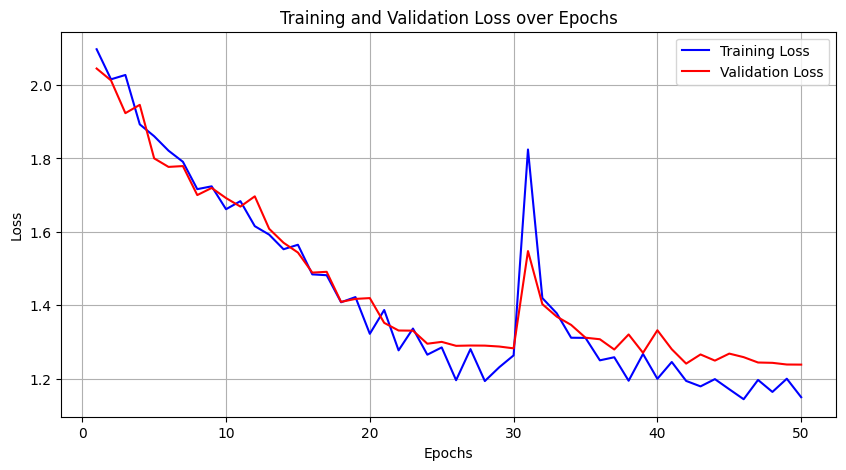

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(range(1,51), trainLoss, 'b-', label='Training Loss')
plt.plot(range(1,51), evalLoss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


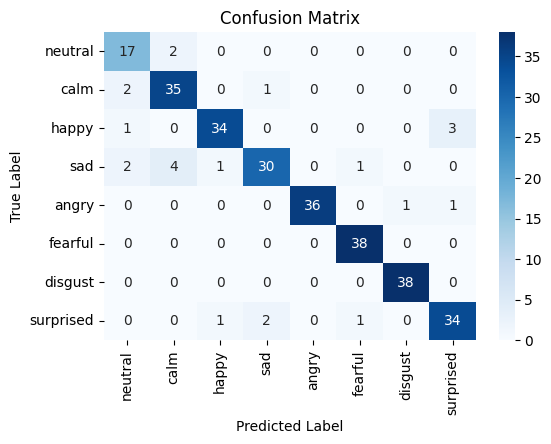

In [37]:
class_labels = [label for label in label2id.keys()]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

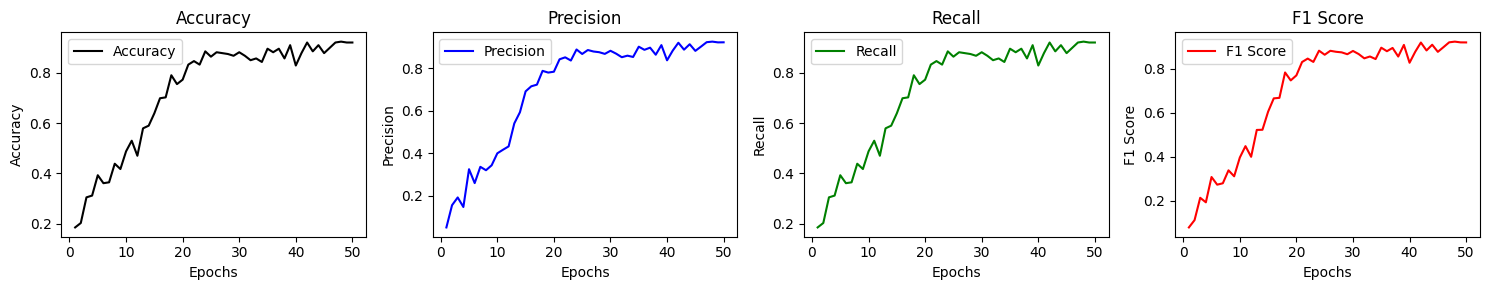

In [55]:

plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.plot(range(1,51), accuracy, 'black', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(range(1,51), precision, 'b', label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(range(1,51), recall, 'g', label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(range(1,51), f1, 'r', label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


### Testing on Samples

In [111]:
def testing(audio_file, audio_length = mean_audio_length):
      audio,sr = librosa.load(audio_file)
      audio = torch.tensor(audio)

      if audio.size(0) < audio_length:
            audio = torch.nn.functional.pad(audio, (0, audio_length - audio.size(0)))
      else:
            excess_length = audio.size(0) - audio_length
            cut_from_each_end = excess_length // 2
            audio = audio[cut_from_each_end:-cut_from_each_end]  # Truncate from both ends equally

      peft_model.eval()
      with torch.no_grad():
            inputs = feature_extractor(audio, sampling_rate=16_000, return_tensors="pt")
            inputs = inputs.to(device)
            outputs = peft_model(**inputs)

      probs = torch.nn.functional.softmax(outputs.logits, dim=1)
      predicted_class = torch.argmax(probs, dim=1).item()
      return audio,probs, predicted_class

In [116]:
audio_file = r'clip_1.mp3'
audio, probs, predicted_class = testing(audio_file, audio_length=max_audio_length)

class_labels = [label for label in label2id.keys()]
probabilities = probs[0].tolist()
class_probabilities = dict(zip(class_labels, probabilities))

formatted_output = ", ".join([f"{label}:{prob:.3f}" for label, prob in class_probabilities.items()])

print(f"Class Labels and Probabilities:\n{formatted_output}")
print(f"Predicted Emotion:\n{id2label[predicted_class]}")

ipd.Audio(audio, rate=sr)

Class Labels and Probabilities:
neutral:0.098, calm:0.090, happy:0.097, sad:0.104, angry:0.307, fearful:0.094, disgust:0.125, surprised:0.086
Predicted Emotion:
angry


In [118]:
audio_file = r'clip_2.mp3'
audio, probs, predicted_class = testing(audio_file, audio_length=max_audio_length)

class_labels = [label for label in label2id.keys()]
probabilities = probs[0].tolist()
class_probabilities = dict(zip(class_labels, probabilities))

formatted_output = ", ".join([f"{label}:{prob:.3f}" for label, prob in class_probabilities.items()])

print(f"Class Labels and Probabilities:\n{formatted_output}")
print(f"Predicted Emotion:\n{id2label[predicted_class]}")

ipd.Audio(audio, rate=sr)

Class Labels and Probabilities:
neutral:0.095, calm:0.089, happy:0.093, sad:0.268, angry:0.110, fearful:0.094, disgust:0.155, surprised:0.095
Predicted Emotion:
sad


In [130]:
audio_file = r'clip_5.mp3'
audio, probs, predicted_class = testing(audio_file, audio_length=max_audio_length)

class_labels = [label for label in label2id.keys()]
probabilities = probs[0].tolist()
class_probabilities = dict(zip(class_labels, probabilities))

formatted_output = ", ".join([f"{label}:{prob:.3f}" for label, prob in class_probabilities.items()])

print(f"Class Labels and Probabilities:\n{formatted_output}")
print(f"Predicted Emotion:\n{id2label[predicted_class]}")

ipd.Audio(audio, rate=sr)

Class Labels and Probabilities:
neutral:0.095, calm:0.096, happy:0.093, sad:0.094, angry:0.172, fearful:0.264, disgust:0.102, surprised:0.084
Predicted Emotion:
fearful


In [135]:
audio_file = r'clip_6.mp3'
audio, probs, predicted_class = testing(audio_file, audio_length=max_audio_length)

class_labels = [label for label in label2id.keys()]
probabilities = probs[0].tolist()
class_probabilities = dict(zip(class_labels, probabilities))

formatted_output = ", ".join([f"{label}:{prob:.3f}" for label, prob in class_probabilities.items()])

print(f"Class Labels and Probabilities:\n{formatted_output}")
print(f"Predicted Emotion:\n{id2label[predicted_class]}")

ipd.Audio(audio, rate=sr)

Class Labels and Probabilities:
neutral:0.107, calm:0.090, happy:0.098, sad:0.085, angry:0.120, fearful:0.096, disgust:0.323, surprised:0.081
Predicted Emotion:
disgust


In [137]:
audio_file = r'clip_7.mp3'
audio, probs, predicted_class = testing(audio_file, audio_length=max_audio_length)

class_labels = [label for label in label2id.keys()]
probabilities = probs[0].tolist()
class_probabilities = dict(zip(class_labels, probabilities))

formatted_output = ", ".join([f"{label}:{prob:.3f}" for label, prob in class_probabilities.items()])

print(f"Class Labels and Probabilities:\n{formatted_output}")
print(f"Predicted Emotion:\n{id2label[predicted_class]}")

ipd.Audio(audio, rate=sr)

Class Labels and Probabilities:
neutral:0.110, calm:0.084, happy:0.243, sad:0.189, angry:0.096, fearful:0.095, disgust:0.085, surprised:0.098
Predicted Emotion:
happy
